<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week16_1_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **7.6** 게이트 순환 신경망(GRU)

- GRU(Gated Recurrent Unit): 게이트 메커니즘이 적용된 RNN 프레임워크의 한 종류

##### **7.6.1 GRU 구조**
- GRU: LSTM에서 사용하는 망각 게이트 + 입력 게이트, 별도의 업데이트 게이트로 구성
- 하나의 게이트 컨트롤러(gate controller)가 망각 게이트, 입력 게이트 모두 제어
- 게이트 컨트롤러가 1을 출력하면 망각 게이트는 열리고 입력 게이트는 닫힘
- 이전 기억이 저장될 때마다 단계별 입력은 삭제
- 출력 게이트 X => 전체 상태 벡터가 매 단계마다 출력, 이전 상태의 어느 부분이 출려고딜지 제어하는 새로운 게이트 컨트롤러 별도로 존재

>**망각 게이트**: 과거 정보를 적당히 초기화(reset) 시키려는 목적으로 시그모드 함수 출력으로 이용
- (0,1)값을 이전 은닉층에 곱함

$$
r_t = \sigma(w_r [h_{t-1}, x_t])
$$

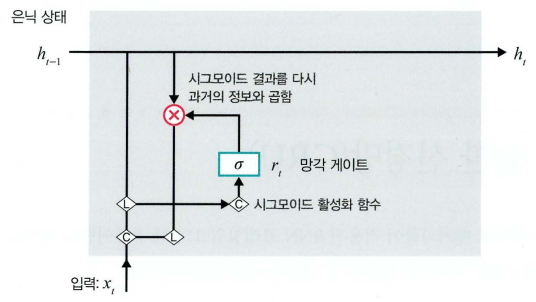

>**업데이트 게이트**: 과거와 현재 정보의 최신화 비율을 결정
- 시그모이드로 출력된 결과($z_t$)는 현시점의 정보량을 결정
- 시그모이드의 출력 = 0 -> 과거 정보 버림 후 1에서 뺀 값($1-z_t$)을 직전 시점의 은닉층 정보와 곱함

$$
z_t = \sigma(w_z [h_{t-1}, x_t])
$$

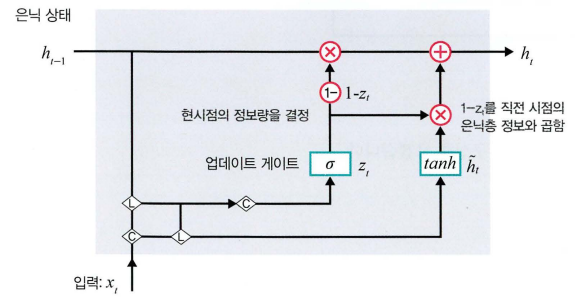

> **후보군**: 현시점의 정보에 대한 후보군 계산
- 과거 은닉층의 정보를 그대로 이용하지 않고 망각 게이트의 결과를 이용하여 후보군 계산
- $*$ = 점 단위 연산 => 벡터를 더할 때 각각의 차원에 맞게 곱하거나 더하는 것 가능
$$
\tilde{h}_t = \tanh(W\cdot[r_t*h_{t-1}, x_t])
$$





> **은닉층 계산**: 업데이트 게이트 결과와 후보군 결과를 결합하여 현시점 은닉층 계산
- 시그모이드 함수의 결과: 현시점에서 결과에 대한 정보량 결정
- 1-시그모이드 함수의 결과: 과거 정보량 결정

$$
h_t = (1-z_t)*h_{t-1}+z_t \times \tilde{h}_t
$$

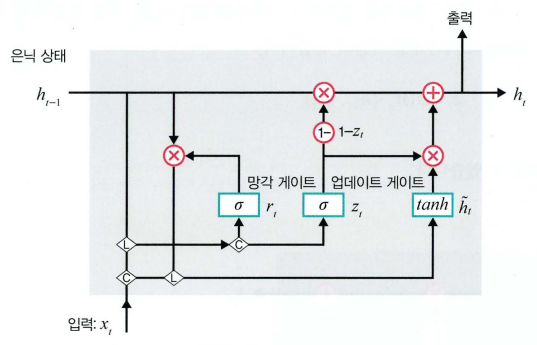


##### **7.6.2 GRU 셀 구현**

In [20]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [21]:
# 데이터 전처리
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [22]:
# 데이터셋 내려받기 및 전처리 적용
from torchvision.datasets import MNIST
download_root ='../chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True,
                      download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False,
                      download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False,
                     download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 125MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 12.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 62.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]


In [23]:
# 데이터셋 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size, # 일반적으로 검증과 테스트 용도의 데이터셋은 섞어서 사용하지 않습니다
                          shuffle=True)          # 예제에서는 다양한 학습을 위해 True로 지정했습니다
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [24]:
# 변수 값 설정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [25]:
# GRU 셀 네트워크
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)   # 1
    self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self):   # 파라미터를 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    x = x.view(-1, x.size(1))
                           # LSTM 셀에서는 gates를 x2h+h2h로 정의했지만
    gate_x = self.x2h(x)   # GRU 셀에서는 개별적인 상태를 유지합니다
    gate_h = self.h2h(hidden)
    gate_x = gate_x.squeeze()
    gate_h = gate_h.squeeze()

    i_r, i_i, i_n = gate_x.chunk(3, 1)   # 총 세 개의 게이트(망각, 입력, 새로운 게이트)를 위해 세개로 쪼갠다.
    h_r, h_i, h_n = gate_h.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + (resetgate * h_n))   # '새로운 게이트'는 탄젠트 활성화 함수가 적용된 게이트

    hy = newgate + inputgate * (hidden - newgate)
    return hy

1. LSTM 셀에서는 4를 곱했지만 GRU 셀에서는 세 개의 게이트가 사용되므로 3을 곱함
  - 게이트는 두 개(망각, 입력 게이트)이지만 탄젠트 활성화 함수가 적용되는 부분을 '새로운 게이트(new gate)'로 정의하여 총 3을 곱함

In [26]:
# 전반적인 네트워크 구조
class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(GRUModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)   # 앞에서 정의한 GRUCell 함수를 불러옵니다
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    hn = h0[0,:,:]   # LSTM 셀에서는 셀 상태에 대해서도 정의했었지만 GRU 셀에서는 셀은 사용되지 않습니다

    for seq in range(x.size(1)):
      hn = self.gru_cell(x[:,seq,:], hn)
      outs.append(hn)
    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

In [27]:
# 옵티마이저와 손실 함수 설정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
   model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [31]:
# 모델 학습 및 성능 검증
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
           labels = Variable(labels.cuda())
        else:
           images = Variable(images.view(-1, seq_dim, input_dim))
           labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
           loss.cuda()

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
           correct = 0
           total = 0
           for images, labels in valid_loader:
               if torch.cuda.is_available():
                  images = Variable(images.view(-1, seq_dim, input_dim).cuda())
               else:
                  images = Variable(images.view(-1, seq_dim, input_dim))

               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)

               if torch.cuda.is_available():
                  correct += (predicted.cpu() == labels.cpu()).sum()
               else:
                  correct += (predicted == labels).sum()

           accuracy = 100 * correct / total
           print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(),
                                                                accuracy))

Iteration: 500. Loss: 1.5284427404403687. Accuracy: 53.779998779296875
Iteration: 1000. Loss: 0.5699767470359802. Accuracy: 76.2699966430664
Iteration: 1500. Loss: 0.3735027313232422. Accuracy: 88.97000122070312
Iteration: 2000. Loss: 0.28032535314559937. Accuracy: 92.9800033569336
Iteration: 2500. Loss: 0.1599244624376297. Accuracy: 95.31999969482422
Iteration: 3000. Loss: 0.08697430044412613. Accuracy: 95.79000091552734
Iteration: 3500. Loss: 0.21204212307929993. Accuracy: 96.75
Iteration: 4000. Loss: 0.03809889033436775. Accuracy: 96.5999984741211
Iteration: 4500. Loss: 0.13486050069332123. Accuracy: 97.18000030517578
Iteration: 5000. Loss: 0.13687370717525482. Accuracy: 97.52999877929688
Iteration: 5500. Loss: 0.14575307071208954. Accuracy: 97.36000061035156
Iteration: 6000. Loss: 0.05782407522201538. Accuracy: 97.47000122070312
Iteration: 6500. Loss: 0.05535880848765373. Accuracy: 97.91000366210938
Iteration: 7000. Loss: 0.045539043843746185. Accuracy: 97.86000061035156
Iteration:

- LSTM 셀 실행했을 때 정확도와 유사
- LSTM셀 사용하든, GRU 셀 사용하든 정확도가 비슷하게 나옴 => 어떤 것이 더 좋다고 말할 수 없음
- 주어진 데이터셋을 다양한 모델에 적용하여 최적의 모델을 찾는 것이 중요

In [10]:
# 테스트 데이터셋을 이용한 모델 예측
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
           images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum')
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [11]:
# 모델 예측 결과
test_loss, test_acc = evaluate(model, test_loader)
print('Test Loss: %5.2f | Test Accuracy: %5.2f' % (test_loss, test_acc))

Test Loss:  2.31 | Test Accuracy:  0.10


##### **7.6.3 GRU 계층 구현**

In [33]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap07/data/

# 3. 파일 목록 확인
!ls

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 31.54 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.
/content/080289/chap07/data/080289/chap07/data
sales.csv  SBUX.csv


In [35]:
# 데이터셋 가져오기
data = pd.read_csv('/content/080289/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [36]:
# 인덱스 설정 및 데이터 타입 변경
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [37]:
# 훈련과 레이블 데이터셋 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [38]:
# 훈련과 테스트 데이터셋 정규화
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [39]:
# 데이터셋 형태 변경
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [40]:
# GRU 모델의 네트워크
class GRU(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):                                                       # 은닉 상태에 대해 0으로 초기화하는 부분으로, LSTM 계층은
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태가 있었지만 GRU는 셀 상태를 정의하지 않습니다.
    output, (hn) = self.gru(x, (h_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [41]:
# 옵티마이저와 손실 함수 지정
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1 # GRU 계층의 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
       print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06489
Epoch: 100, loss: 0.02992
Epoch: 200, loss: 0.02691
Epoch: 300, loss: 0.02494
Epoch: 400, loss: 0.02314
Epoch: 500, loss: 0.02146
Epoch: 600, loss: 0.01985
Epoch: 700, loss: 0.01871
Epoch: 800, loss: 0.01797
Epoch: 900, loss: 0.01759


In [43]:
# 그래프 출력을 위한 전처리
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

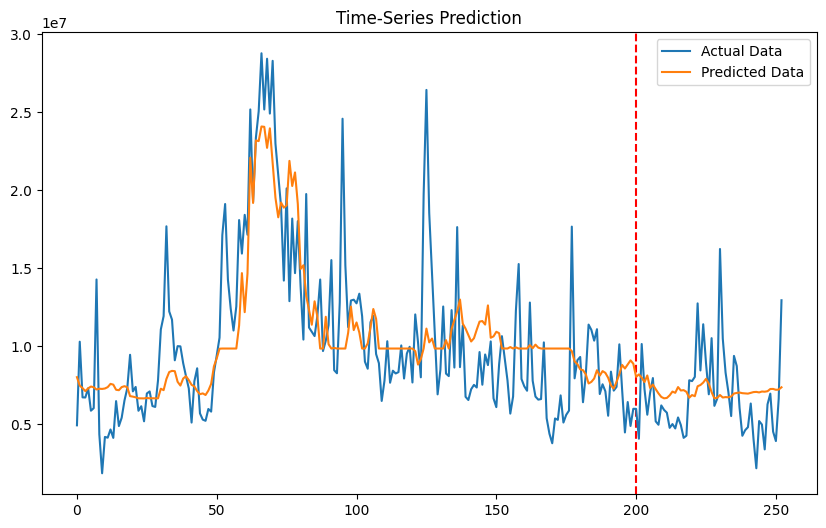

In [44]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### **7.7** 양방향 RNN

- 양방향 RNN(bididectional RNN): 이전 시점 데이터뿐만 아니라 이후 시점의 데이터도 함께 활용하여 출력 값을 예측하고자 하는 것

##### **7.7.1 양방향 RNN 구조**
- 하나의 출력 값을 예측하는 데 메모리 셀 두 개 사용
- 첫 번째 메모리 셀: 이전 시점의 은닉 상태(forward states) 전달받아 현재의 은닉 상태 계산 => 초록색 메모리 셀에 해당
- 두 번째 메모리 셀: 다음 시점의 은닉 상태(backward states) 전달받아 현재의 은닉 상태 계산 => 노란색 메모리 셀에 해당
- 값 두 개를 모두 출력층에서 출력 값 예측하는 데 사용

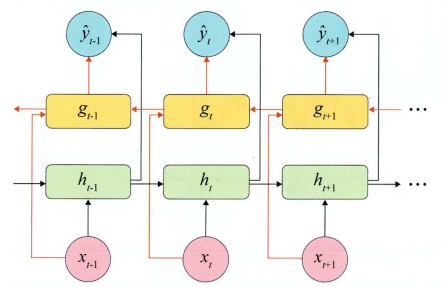

##### **7.7.2 양방향 LSTM 구현**

In [45]:
# 모델을 생성하고 학습
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('/content/080289/chap07/data/SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

ms = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]
y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [46]:
# 모델의 네트워크
class biLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
      super(biLSTM, self).__init__()
      self.num_classes = num_classes
      self.num_layers = num_layers
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.seq_length = seq_length

      self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, bidirectional=True, batch_first=True)   # 1
      self.fc = nn.Linear(hidden_size*2, num_classes)   # 2
      self.relu = nn.ReLU()

  def forward(self, x):
      h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 2'
      c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 2''
      out, _ = self.lstm(x, (h_0, c_0))
      out = self.fc(out[:, -1, :])   # 마지막 시간(time step상 마지막 단계)의 은닉 상태
      out = self.relu(out)
      return out

1. LSTM 계층을 정의하는 부분(nn.LSTM)에 bidrectional=True 옵션을 사용하면 양방향 LSTM 사용하겠다는 의미
  - bidrectional=True 옵션 => 양방향 RNN, 양방향 GRU
2. 2' 2'' LSTM 과 양방향 LSTM의 차이: 입력 데이터가 전방향, 역방향 학습에 모두 전달되며 그 결과 모두 출력에 반영
  - 한 번 학습하는 데 두 개의 계층이 필요하기 때문에 LSTM과 다르게 은닉 상태, 셀 상태에 2를 곱하고
  - 마지막 출력층에도 2를 곱해야 함

  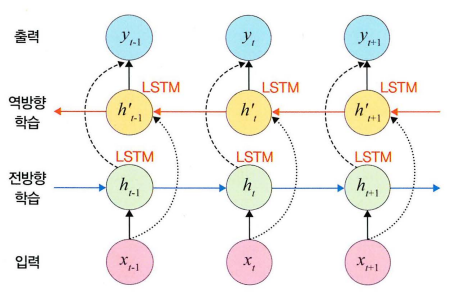

In [47]:
# 양방향 LSTM 모델 학습
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers,
               X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
       print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07436
Epoch: 100, loss: 0.06362
Epoch: 200, loss: 0.05353
Epoch: 300, loss: 0.04467
Epoch: 400, loss: 0.03759
Epoch: 500, loss: 0.03226
Epoch: 600, loss: 0.02846
Epoch: 700, loss: 0.02584
Epoch: 800, loss: 0.02406
Epoch: 900, loss: 0.02283


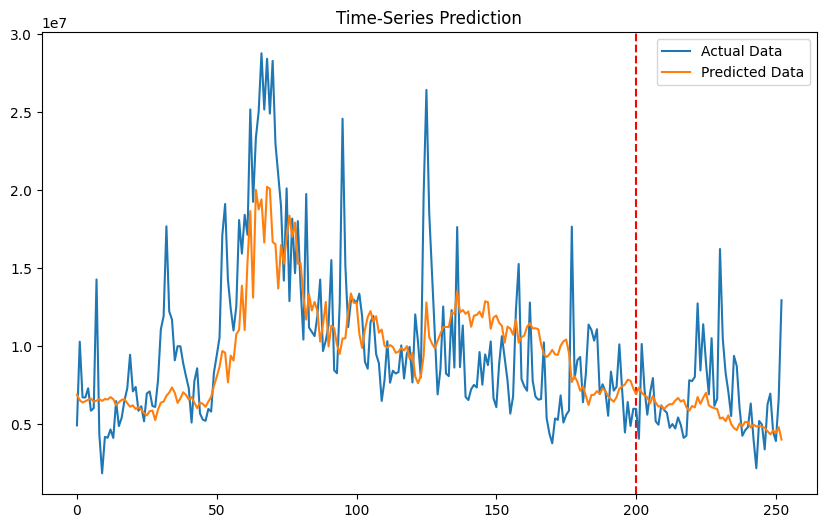

In [48]:
# 모델 평가
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

**시계열 분석과 관련한 다양한 모델의 구현 방법**
- 시계열 데이터: 일반적인 숫자의 나열보다는 한글 및 영문으로 사람의 언어(자연어)로 구현된 데이터가 대부분
    
    => 데이터에 대한 전처리가 가장 중요